In [1]:
# Imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from helper_functions.load_data import load_data
from sklearn import set_config
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    accuracy_score,
    balanced_accuracy_score,
    roc_curve,
    roc_auc_score,
    f1_score,
    classification_report,
)

#### Read in data

In [2]:
titanic = load_data(
    "train.csv",
    "https://spiced.space/regularised-aniseed/ds-course/_downloads/6df11ef5f535b97c47efc5873d018bf1/train.csv",
    sep=",",
)
titanic.head()
titanic["Pclass"].value_counts()
titanic["Survived"].value_counts()

Loading in train.csv...
Data set successfully loaded.



0    549
1    342
Name: Survived, dtype: int64

#### Feature engineering

#### Build model pipeline

In [3]:
# Define features
categorical_features = ["Pclass"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop="first")

# Build preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("categoric", categorical_transformer, categorical_features),
    ]
)

# Build pipeline
pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            LogisticRegression(C=1e5, class_weight="balanced", random_state=0),
        ),
    ]
)
pipe


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categoric',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Pclass'])])),
                ('classifier',
                 LogisticRegression(C=100000.0, class_weight='balanced',
                                    random_state=0))])

#### Train-test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    titanic[["Pclass"]],
    titanic["Survived"],
    test_size=0.2,
    random_state=42,
)

#### Train the model

In [13]:
pipe.fit(X_train, y_train)
print(f"The model's coefficients are {pipe.named_steps['classifier'].coef_[0]} and its intercept is {pipe.named_steps['classifier'].intercept_[0]:.5}.")

The model's coefficients are [-0.50248587 -1.58231447] and its intercept is 0.94107.


#### Predict and evaluate

In [19]:
print(classification_report(y_true=y_test, y_pred=pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      0.67      0.71       105
           1       0.59      0.69      0.64        74

    accuracy                           0.68       179
   macro avg       0.67      0.68      0.67       179
weighted avg       0.69      0.68      0.68       179



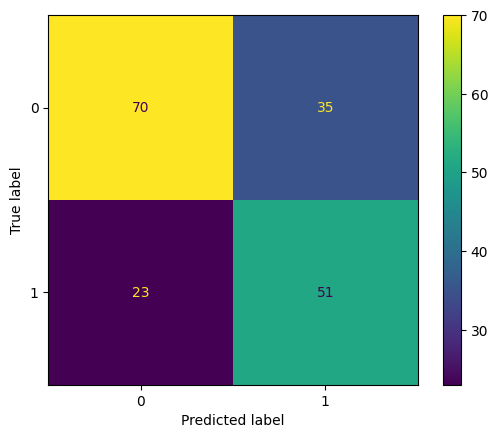

In [21]:
# Confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, pipe.predict(X_test), normalize=None
)

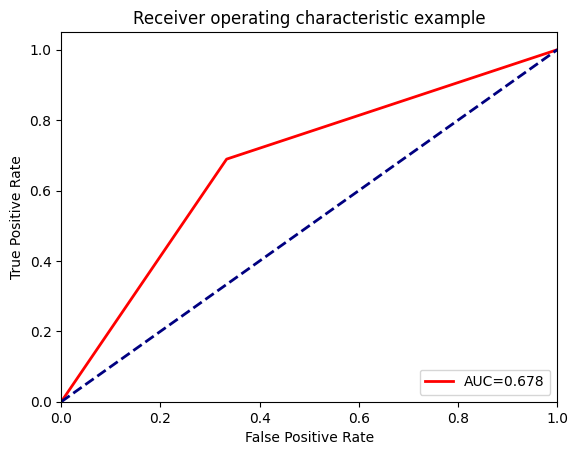

In [22]:
fpr, tpr, thresh = roc_curve(y_test, pipe.predict(X_test))
roc_auc = roc_auc_score(y_test, pipe.predict(X_test))
# Plot ROC
fig, ax = plt.subplots()
lw = 2
ax.plot(
    fpr, tpr,
    lw=lw,
    label=f"AUC={roc_auc:.3f}",
    color="red",
)
ax.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()